### Transaction Fraud EDA

Проанализируем данные, чтобы выявить ключевые взаимосвязи между мошенническими транзакциями и различными признаками.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
df = pd.read_parquet('data/transaction_fraud_data.parquet')
df.head()

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,...,is_card_present,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,...,False,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,False,False,False,"{'num_transactions': 1197, 'total_amount': 334...",False
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,3368.97,BRL,Brazil,...,False,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,True,True,False,"{'num_transactions': 509, 'total_amount': 2011...",True
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762,Grocery,physical,Whole Foods,102582.38,JPY,Japan,...,False,Firefox,web,218864e94ceaa41577d216b149722261,10.194.159.204,False,False,False,"{'num_transactions': 332, 'total_amount': 3916...",False
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466,Gas,major,Exxon,630.60,AUD,Australia,...,False,iOS App,mobile,70423fa3a1e74d01203cf93b51b9631d,17.230.177.225,False,False,False,"{'num_transactions': 764, 'total_amount': 2201...",False
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,...,False,Chrome,web,9880776c7b6038f2af86bd4e18a1b1a4,136.241.219.151,True,False,False,"{'num_transactions': 218, 'total_amount': 4827...",True


##### Сразу сделаем колонку с актуальным курсом валюты

In [22]:
def get_exch_rate():
    df_currency = pd.read_parquet('data/historical_currency_exchange.parquet')
    # Создаем словарь для быстрого доступа к курсам валют
    # Ключ - дата, значение - словарь валют и их курсов
    exchange_dict = df_currency.set_index('date').to_dict('index')

    # Функция для конвертации валюты в USD
    def convert_to_usd(row):
        date = row['timestamp'].date()
        currency = row['currency']

        rate = exchange_dict[date][currency]
        return rate

    # Добавляем новую колонку
    df['exchange_rate'] = df.apply(convert_to_usd, axis=1)
get_exch_rate()

##### Раскроем признаки из словаря last_hour_activity в отдельные колонки

In [23]:
for key in df.iloc[0]['last_hour_activity'].keys():
    df['last_hour_' + key] = df.apply(lambda row: row['last_hour_activity'][key], axis=1)

##### Переведем все суммы в доллары, чтобы их можно было сравнивать друг с другом.

In [24]:
df['amount'] /= df['exchange_rate']
df['last_hour_total_amount'] /= df['exchange_rate']
df['last_hour_max_single_amount'] /= df['exchange_rate']

##### Удалим то, что нам явно не понадобится

In [25]:
df = df.drop(['transaction_id', 'card_number', 'last_hour_activity'], axis=1)

In [26]:
# это для себя чтоб не ждать шаги выше

df.to_parquet('data/transaction_fraud_data_processed.parquet')
df = pd.read_parquet('data/transaction_fraud_data_processed.parquet')

In [27]:
df.head()

,customer_id,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,city,city_size,...,is_outside_home_country,is_high_risk_vendor,is_weekend,is_fraud,exchange_rate,last_hour_num_transactions,last_hour_total_amount,last_hour_unique_merchants,last_hour_unique_countries,last_hour_max_single_amount
0,CUST_72886,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,394.658011,GBP,UK,Unknown City,medium,...,False,False,False,False,0.747153,1197,4.483492e+07,105,12,2.577089e+06
1,CUST_70474,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,619.905757,BRL,Brazil,Unknown City,medium,...,True,True,False,True,5.434649,509,3.701207e+06,100,12,9.474609e+05
2,CUST_10715,2024-09-30 00:00:02.273762,Grocery,physical,Whole Foods,719.506409,JPY,Japan,Unknown City,medium,...,False,False,False,False,142.573268,332,2.746928e+05,97,12,1.299151e+04
3,CUST_16193,2024-09-30 00:00:02.297466,Gas,major,Exxon,436.808287,AUD,Australia,Unknown City,medium,...,False,False,False,False,1.443654,764,1.524784e+07,105,12,1.424024e+06
4,CUST_87572,2024-09-30 00:00:02.544063,Healthcare,medical,Medical Center,434.430069,NGN,Nigeria,Unknown City,medium,...,True,False,False,True,1668.736400,218,2.892989e+03,88,12,6.934776e+02


##### Так как сумма транзакции очень важный и непрерывный показатель, посмотрим есть ли у нас выбросы

<Axes: ylabel='amount'>

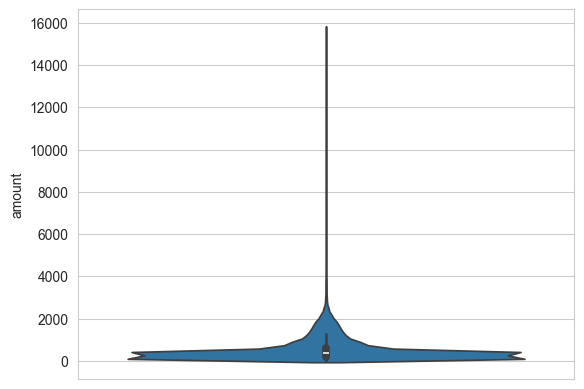

In [28]:
sns.violinplot(df['amount'])

##### Распределение намекает, что может помочь логарифм, проверим:

<Axes: ylabel='amount'>

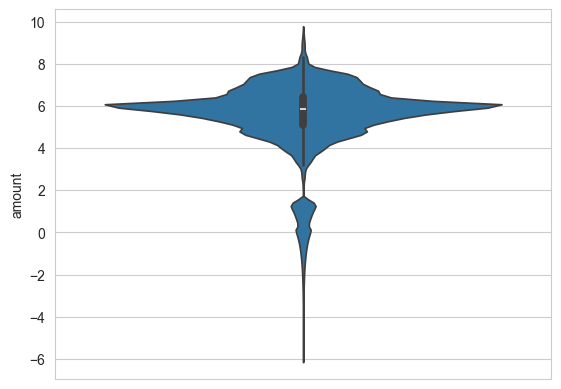

In [29]:
sns.violinplot(np.log(df['amount']))

##### Не нормальное конечно, но явно получше. Прологарифмируем все суммы.

In [30]:
df['amount'] = np.log(df['amount'])
df['last_hour_total_amount'] = np.log(df['last_hour_total_amount'])
df['last_hour_max_single_amount'] = np.log(df['last_hour_max_single_amount'])

### Рассмотрим, как распределяются fraud/nonfraud в зависимости от признаков

##### Рассмотрим общую корреляцию для числовых/бинарных признаков

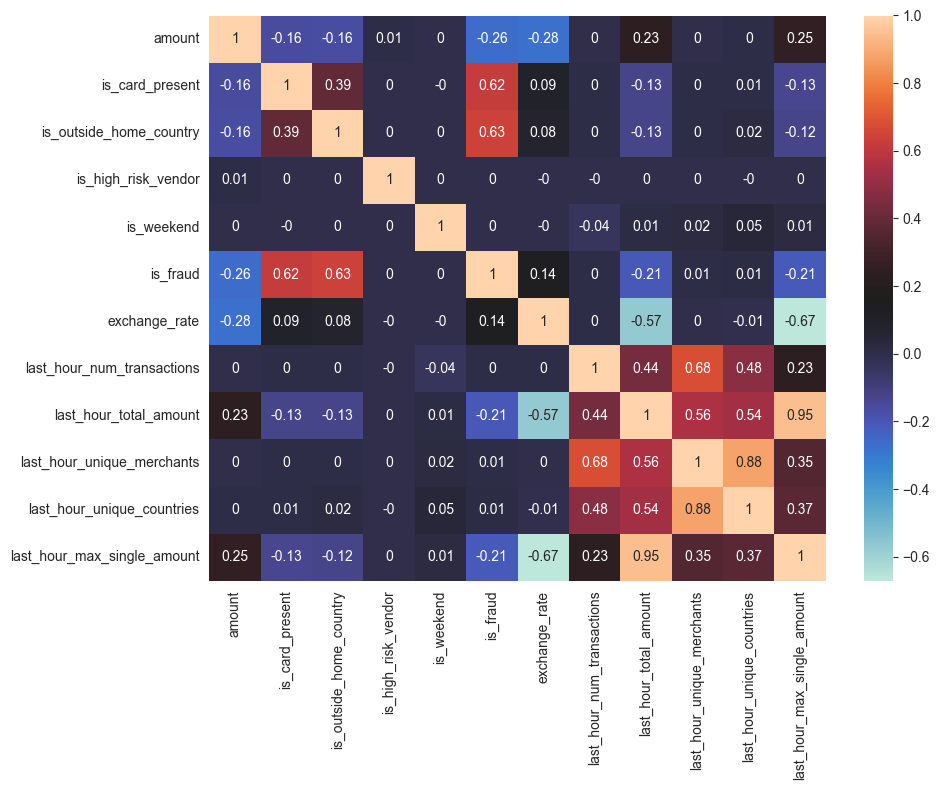

In [31]:
numeric_bool_cols = df.select_dtypes(include=['float', 'int', 'bool']).columns

corr = df[numeric_bool_cols].corr()

sns.heatmap(corr, annot=corr.round(2), cmap='icefire')
plt.gcf().set_size_inches(10, 8)
plt.tight_layout()
plt.show()

##### Мы видим что мошенничают чаще если карта используется физически, а также в домашней стране клиента. Также видна зависимость от exchange_rate что вероятно на самом деле связано со страной клиента. Из необычного, можно выделить, что чаще мошенничают на небольших суммах (без логарифма коэффициент был наоборот положительный). Похожие коэффициенты имеют и максимальная/общая суммы за последний час.
Дополнительно можно отметить что is_high_risk_vendor и is_weekend - по сути бесполезные признаки ни на что не влияющие. Также бросается в глаза, что признаки статистики за последний час очень хорошо коррелируют друг с другом, что в целом логично.

##### Нормальные транзакции, несмотря на то что их в разы больше, сконцентрированы в узком диапазоне, относительно мошеннических. Распределение мошеннических разбивается на два участка - операций с очень маленькими суммами, и с "нормальными" суммами. Теперь понятно чем объясняется значение коэффициента корреляции до/после лог преобразования

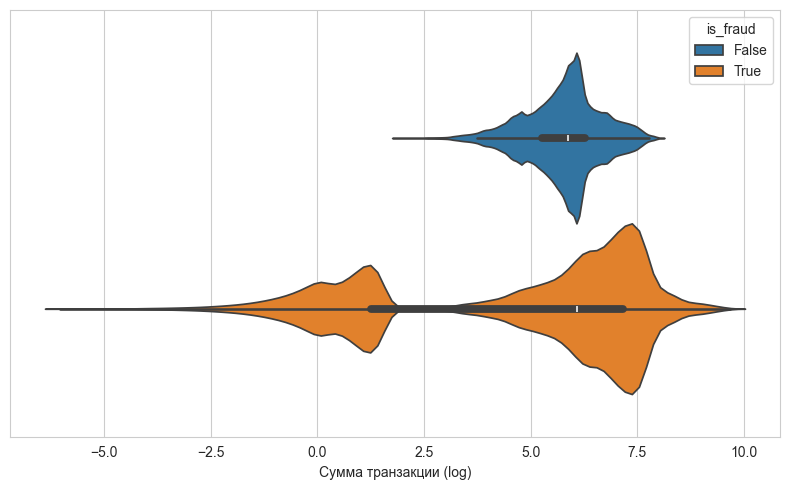

In [32]:
sns.violinplot(data=df, x='amount', hue='is_fraud')
plt.xlabel('Сумма транзакции (log)')
plt.gcf().set_size_inches(8, 5)
plt.tight_layout()
plt.show()

##### Теперь посмотрим на доли мошеннических операций в зависимости от значений категориальных признаков.

##### В данном наборе данных в Бразилии, Нигерии, Мексике и России существенно чаще мошенничают.

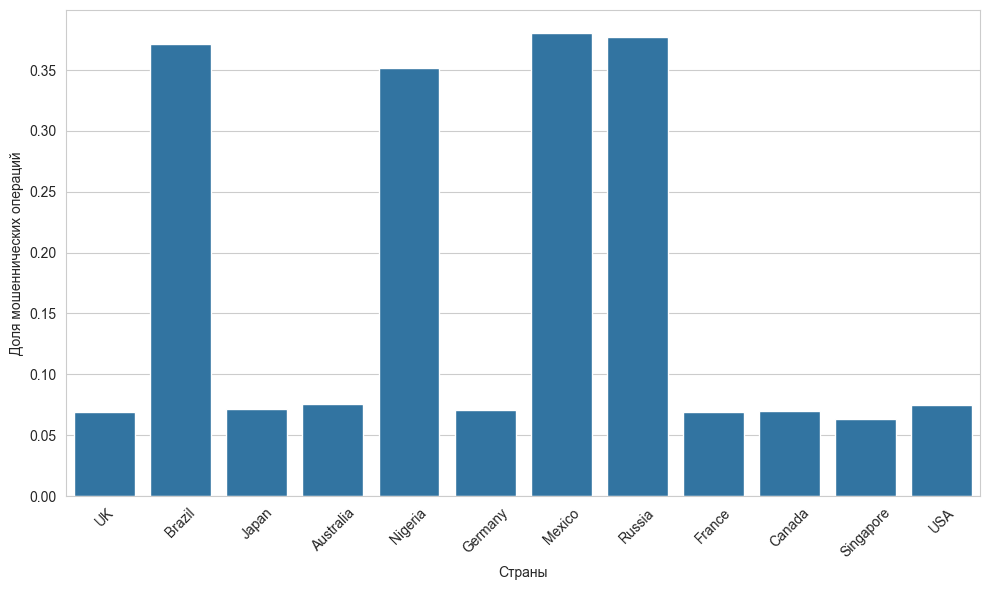

In [33]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='country', y='is_fraud', estimator='mean', errorbar=None)

plt.ylabel('Доля мошеннических операций')
plt.xlabel('Страны')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### С валютами ситуация ожидаемо аналогичная

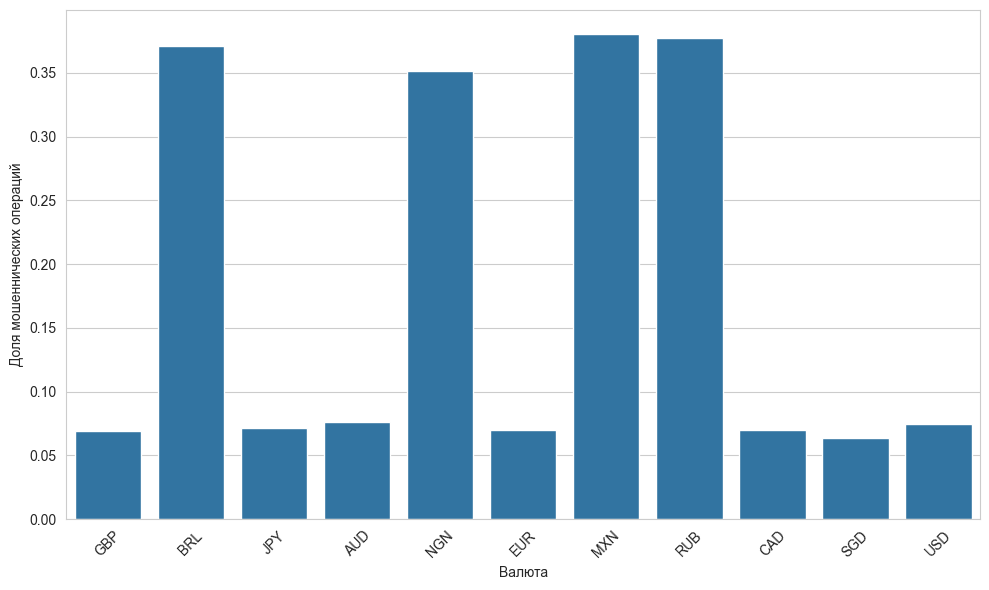

In [34]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='currency', y='is_fraud', estimator='mean', errorbar=None)

plt.ylabel('Доля мошеннических операций')
plt.xlabel('Валюта')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### По категории продавца везде по 20% - ничего интересного

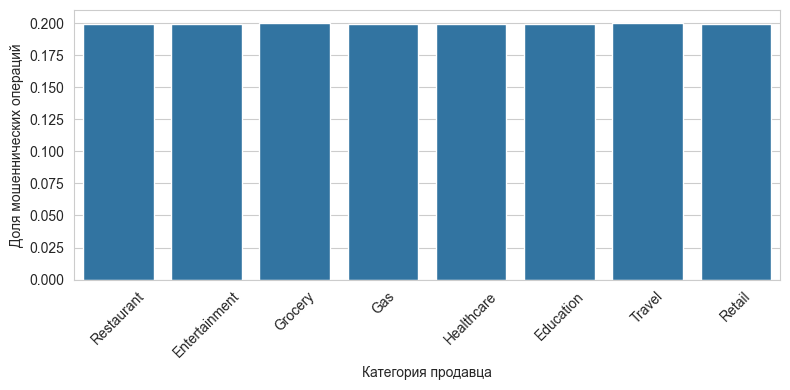

In [35]:
plt.figure(figsize=(8, 4))
sns.barplot(data=df, x='vendor_category', y='is_fraud', estimator='mean', errorbar=None)

plt.ylabel('Доля мошеннических операций')
plt.xlabel('Категория продавца')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### То же самое и с типом продавца

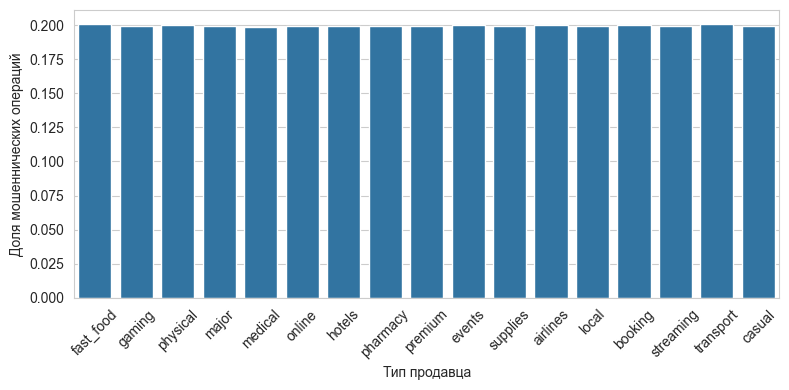

In [36]:
plt.figure(figsize=(8, 4))
sns.barplot(data=df, x='vendor_type', y='is_fraud', estimator='mean', errorbar=None)

plt.ylabel('Доля мошеннических операций')
plt.xlabel('Тип продавца')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### По типу карты аналогично

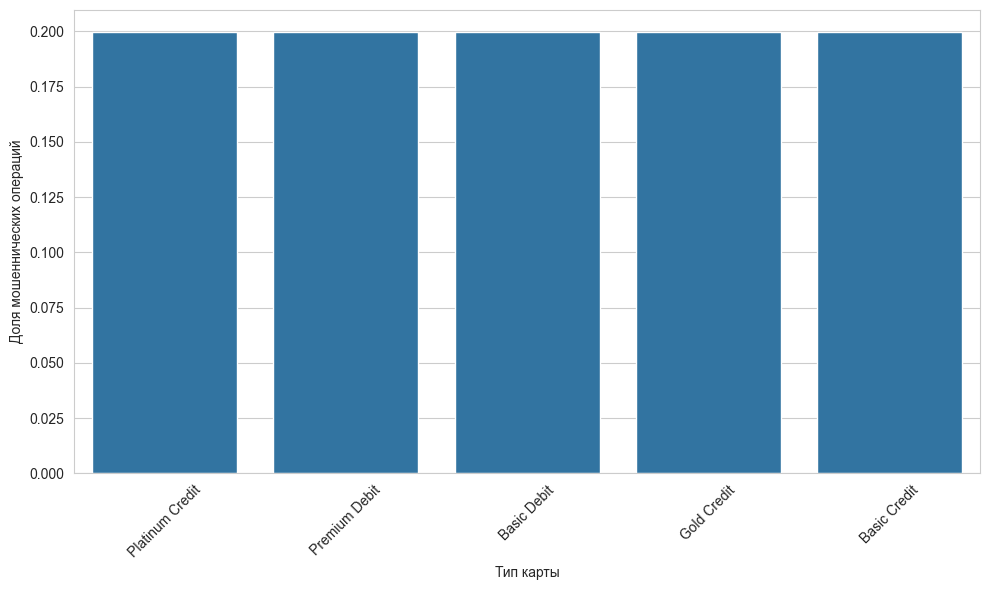

In [37]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='card_type', y='is_fraud', estimator='mean', errorbar=None)

plt.ylabel('Доля мошеннических операций')
plt.xlabel('Тип карты')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### А еще в наборе данных мошеннические 100% операций проведенных с помощью NFC, чипа и магнитной полоски

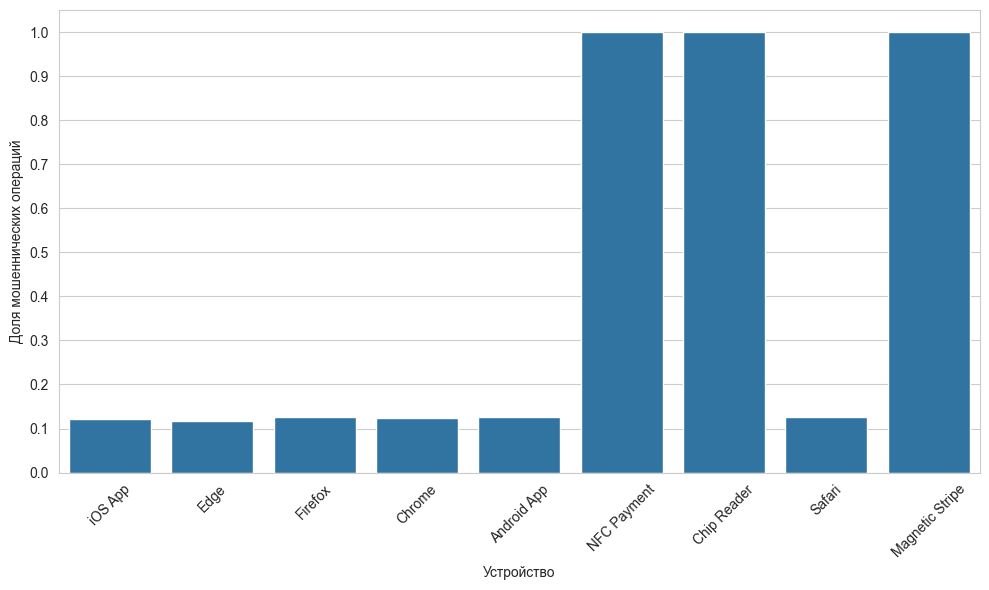

In [38]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='device', y='is_fraud', estimator='mean', errorbar=None)

plt.ylabel('Доля мошеннических операций')
plt.xlabel('Устройство')
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 1.01, 0.1))
plt.tight_layout()
plt.show()

##### Похожая ситуация и с "каналом"

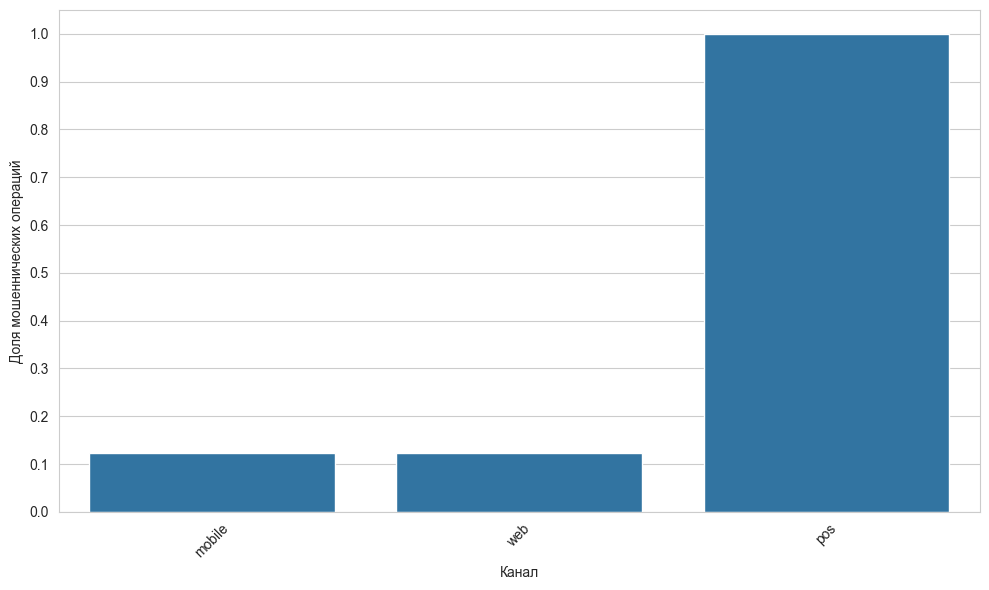

In [39]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='channel', y='is_fraud', estimator='mean', errorbar=None)

plt.ylabel('Доля мошеннических операций')
plt.xlabel('Канал')
plt.yticks(np.arange(0, 1.01, 0.1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Еще 100% физических операций с картой мошеннические

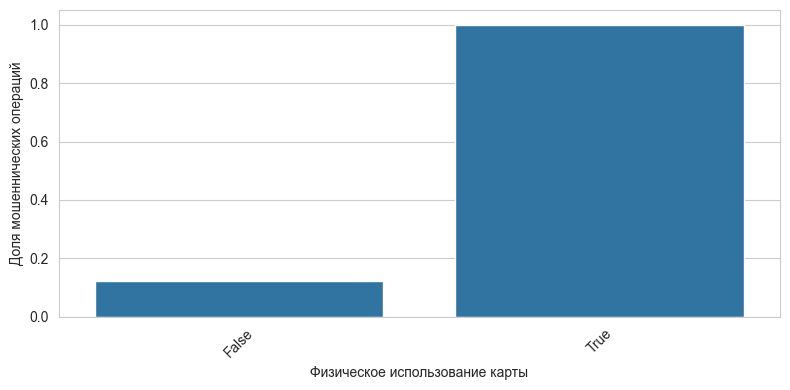

In [40]:
plt.figure(figsize=(8, 4))
sns.barplot(data=df, x='is_card_present', y='is_fraud', estimator='mean', errorbar=None)
plt.ylabel('Доля мошеннических операций')
plt.xlabel('Физическое использование карты')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Всего 2% операций вне страны клиента мошеннические, а внутри страны - 56%.

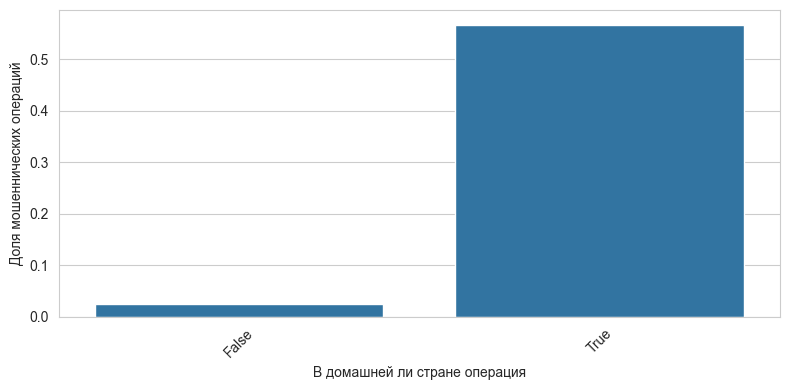

In [41]:
plt.figure(figsize=(8, 4))
sns.barplot(data=df, x='is_outside_home_country', y='is_fraud', estimator='mean', errorbar=None)
plt.ylabel('Доля мошеннических операций')
plt.xlabel('В домашней ли стране операция')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### С днями недели те же 20%

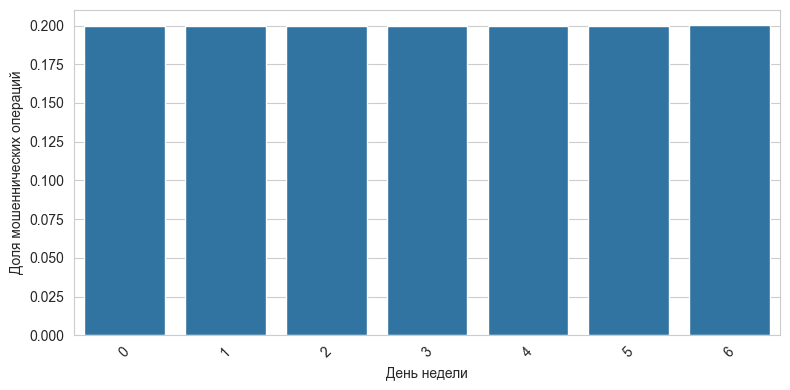

In [42]:
df['weekday'] = df['timestamp'].dt.weekday
plt.figure(figsize=(8, 4))
sns.barplot(data=df, x='weekday', y='is_fraud', estimator='mean', errorbar=None)
plt.ylabel('Доля мошеннических операций')
plt.xlabel('День недели')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Ночью (с 1 до 4 часов) мошеннических операций намного больше. Но пока неясно местное ли время в timestamp и с чем именно это связано.

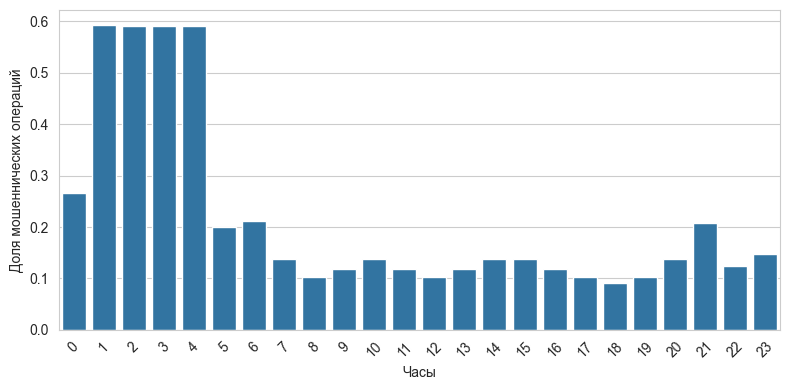

In [43]:
df['hour'] = df['timestamp'].dt.hour
plt.figure(figsize=(8, 4))
sns.barplot(data=df, x='hour', y='is_fraud', estimator='mean', errorbar=None)
plt.ylabel('Доля мошеннических операций')
plt.xlabel('Часы')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Изобразим мошеннические транзакции отдеьно. Теперь видно, что глубокой ночью намного больше мошеннических операций, когда нормальные операции чаще происходят в другое время.

<Axes: xlabel='hour'>

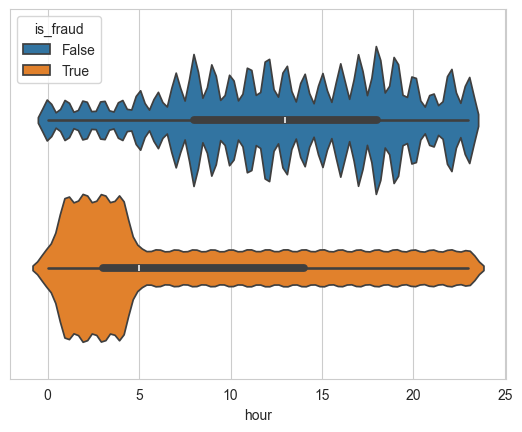

In [44]:
sns.violinplot(data=df, x='hour', hue='is_fraud')

##### Средняя доля мошеннических операций у различных клиентов также у всех почти одинаковая и едва ли отличается от знакомых нам 20%

<Axes: ylabel='is_fraud'>

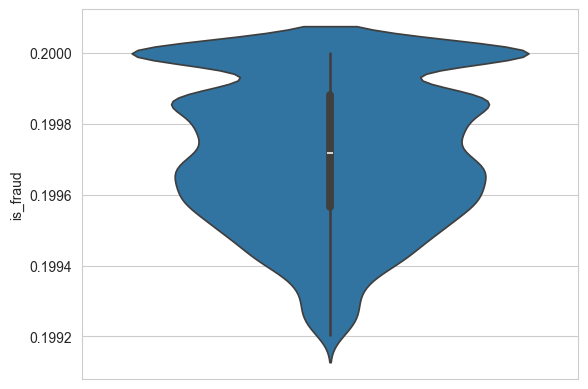

In [45]:
sns.violinplot(df.groupby('customer_id')['is_fraud'].mean())

##### Также видим что мошенничество не зависит от количества уникльных ip адресов откуда покупает клиент

<Axes: xlabel='unique_ips'>

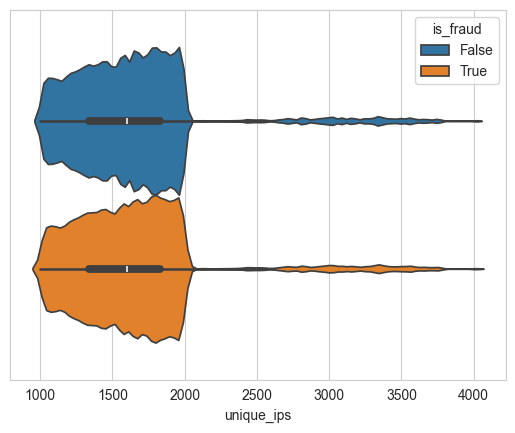

In [57]:
unique_ips = df.groupby('customer_id')['ip_address'].nunique()
df = df.merge(unique_ips, on='customer_id')
df.rename(columns={'ip_address_y': 'unique_ips'}, inplace=True)
df.rename(columns={'ip_address_x': 'ip_address'}, inplace=True)
sns.violinplot(data=df, x='unique_ips', hue='is_fraud')

##### И не зависит от количества уникальных устройств

<Axes: xlabel='unique_devices'>

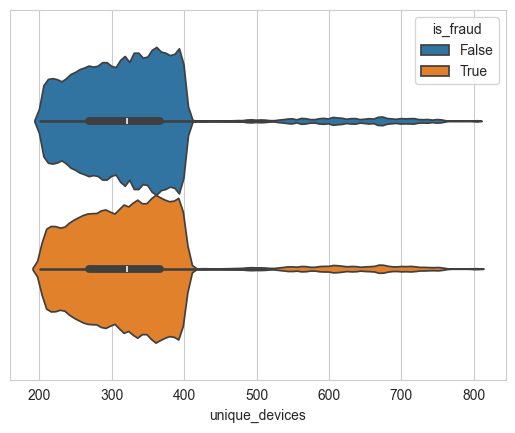

In [67]:
unique_devices = df.groupby('customer_id')['device_fingerprint'].nunique()
df = df.merge(unique_devices, on='customer_id')
df.rename(columns={'device_fingerprint_y': 'unique_devices'}, inplace=True)
df.rename(columns={'device_fingerprint_x': 'device_fingerprint'}, inplace=True)
sns.violinplot(data=df, x='unique_devices', hue='is_fraud')

#### Рассмотрим как влияют на таргет значения, которые изначально были запрятаны в словарь

##### Количество транзакций за последний час - не влияет

<Axes: xlabel='last_hour_num_transactions'>

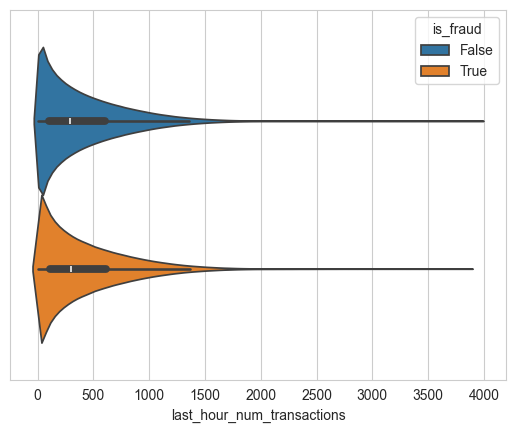

In [69]:
sns.violinplot(data=df, x='last_hour_num_transactions', hue='is_fraud')

##### Для общей суммы распределения отличаются, на что ранее нам намекал коэффициент корреляции

<Axes: xlabel='last_hour_total_amount'>

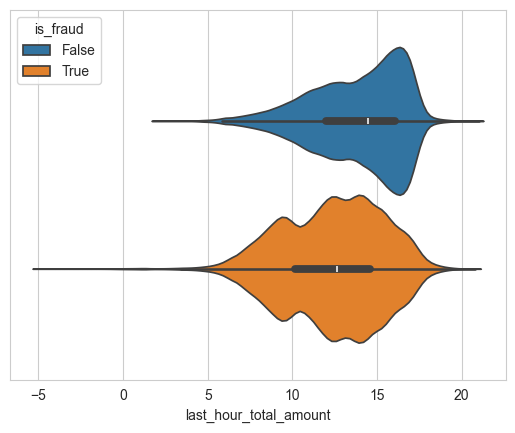

In [70]:
sns.violinplot(data=df, x='last_hour_total_amount', hue='is_fraud')

##### Количество уникальных продавцов - не влияет

<Axes: xlabel='last_hour_unique_merchants'>

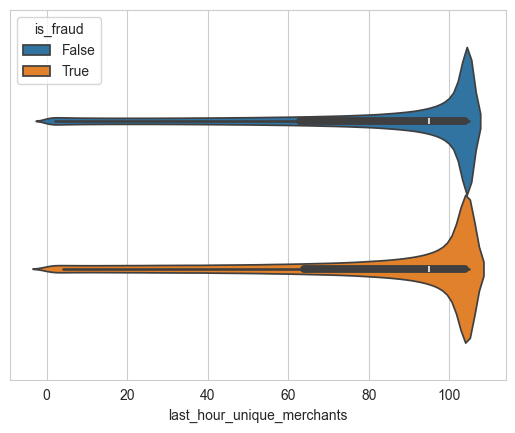

In [71]:
sns.violinplot(data=df, x='last_hour_unique_merchants', hue='is_fraud')

##### Количество стран - не влияет

<Axes: xlabel='last_hour_unique_countries'>

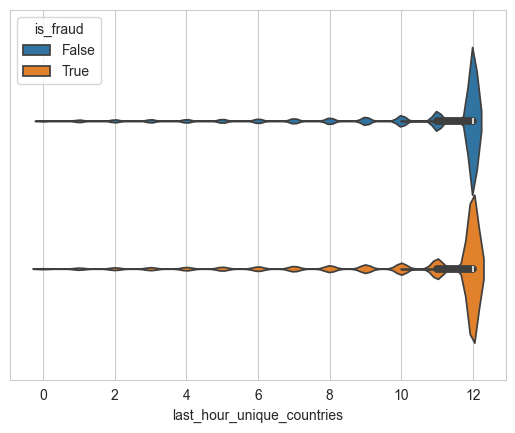

In [72]:
sns.violinplot(data=df, x='last_hour_unique_countries', hue='is_fraud')

##### А для максимальной суммы за последний час видим такой же перекос как для общей суммы, что логично.

<Axes: xlabel='last_hour_max_single_amount'>

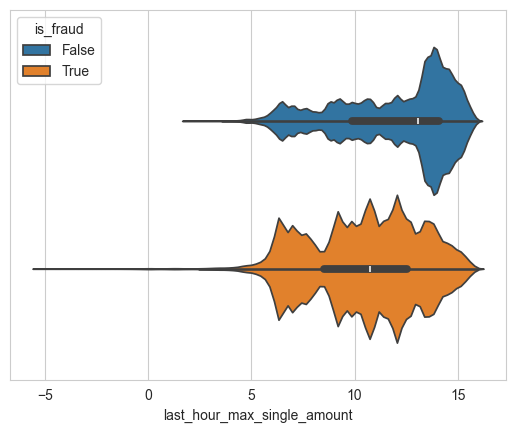

In [73]:
sns.violinplot(data=df, x='last_hour_max_single_amount', hue='is_fraud')

#### Построим модель и оценим feature importance

In [83]:
X = df.drop(['is_fraud', 'customer_id', 'device_fingerprint', 'ip_address', 'timestamp'], axis=1)
y = df['is_fraud']

##### Обучим катбуст потому что он неплохо подбирает параметры из коробки, сам обрабатывает категориальные фичи и учится на гпу. И разумеется с ним лего получить важности фичей.

In [84]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split

cat_features = X.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

In [90]:
# Инициализация и обучение модели
model = CatBoostClassifier(
    iterations=200,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=True,
    random_seed=42,
    task_type='GPU'
)

##### Получем очень высокую точность.

In [91]:
model.fit(train_pool, eval_set=test_pool, use_best_model=True)

Learning rate set to 0.066197


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9829654	best: 0.9829654 (0)	total: 587ms	remaining: 1m 56s
1:	total: 1.04s	remaining: 1m 42s
2:	total: 1.49s	remaining: 1m 37s
3:	total: 1.95s	remaining: 1m 35s
4:	total: 2.4s	remaining: 1m 33s
5:	test: 0.9847353	best: 0.9847353 (5)	total: 2.87s	remaining: 1m 32s
6:	total: 3.31s	remaining: 1m 31s
7:	total: 3.73s	remaining: 1m 29s
8:	total: 4.15s	remaining: 1m 28s
9:	total: 4.55s	remaining: 1m 26s
10:	test: 0.9880491	best: 0.9880491 (10)	total: 5.12s	remaining: 1m 28s
11:	total: 5.63s	remaining: 1m 28s
12:	total: 6.17s	remaining: 1m 28s
13:	total: 6.72s	remaining: 1m 29s
14:	total: 7.15s	remaining: 1m 28s
15:	test: 0.9906530	best: 0.9906530 (15)	total: 7.7s	remaining: 1m 28s
16:	total: 8.16s	remaining: 1m 27s
17:	total: 8.6s	remaining: 1m 26s
18:	total: 9.03s	remaining: 1m 26s
19:	total: 9.53s	remaining: 1m 25s
20:	test: 0.9914550	best: 0.9914550 (20)	total: 10.1s	remaining: 1m 26s
21:	total: 10.5s	remaining: 1m 25s
22:	total: 11.1s	remaining: 1m 25s
23:	total: 11.5s	remainin

In [148]:
model.save_model('catboost_fraud_classifier')
# model.load_model('catboost_fraud_classifier')

##### Оценим насколько хорошо модель предсказывает мошеннические транзакции

##### Почти для всего тестового набора модель предсказывает верно

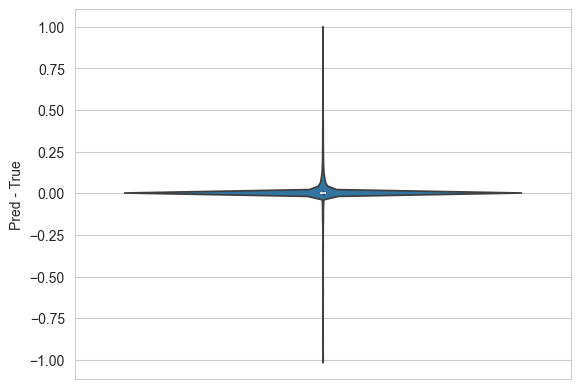

In [143]:
y_pred = model.predict_proba(X_test)
sns.violinplot(y_pred[:, 1] - y_test)
plt.ylabel('Pred - True')
plt.show()

In [92]:
# Получение важности признаков
importances = model.get_feature_importance(train_pool)
feature_names = X.columns

feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

##### На графике ниже признаки отсортированы по важности. В целом первые 5 признаков на 80% описывают поведение модели, а 10 - на 97%

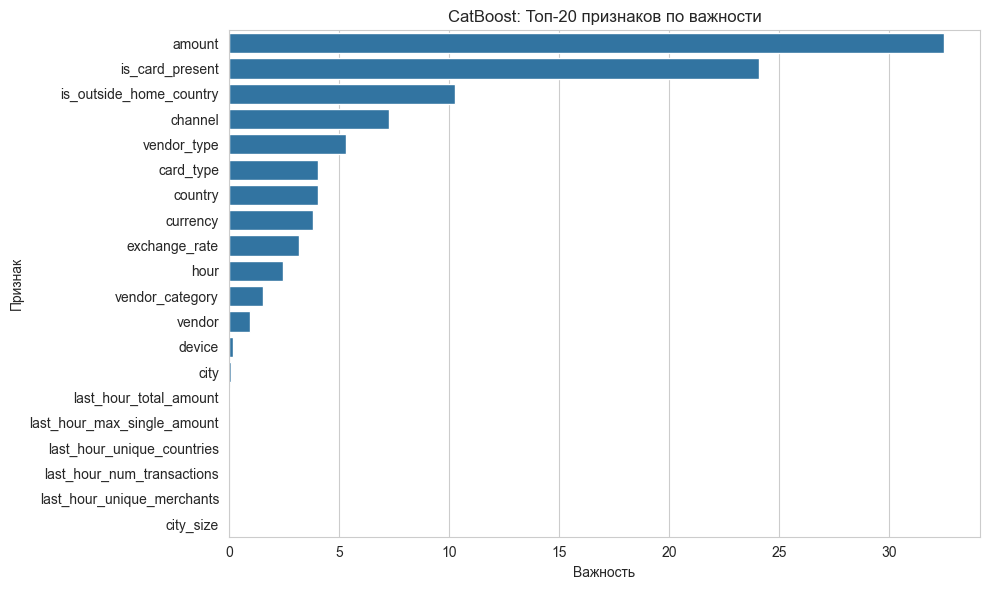

In [94]:
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(20), x='importance', y='feature')
plt.title('CatBoost: Топ-20 признаков по важности')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

##### Примечательно что vendor_type входит в первую пятерку, хотя ранее мы видели что для каждого типа вендора мошеннических операций ровно 20%. Значит есть какая-то неучтенная комбинация признаков или это ошибка. Аналогичная ситуация с card_type. Для остальных признаков причины их важности, учитывая предыдущий анализ, понятны.

##### Попробуем посмотреть по shap-values как все-таки влияют на предсказания vendor_type и card_type

In [ ]:
# Получаем SHAP-значения (включая base value в первой колонке)
shap_values = model.get_feature_importance(
    data=train_pool, type='ShapValues'
)

# Первая колонка — base value (ожидаемое значение log-odds / logloss)
# Остальные — contribution признаков
shap_values = shap_values[:, 1:]  # удалим base value

# Преобразуем в DataFrame
shap_df = pd.DataFrame(shap_values, columns=X_train.columns)

##### Видим что тип карты в отдельных случаях сильно влияет на предсказание.

<Axes: ylabel='card_type'>

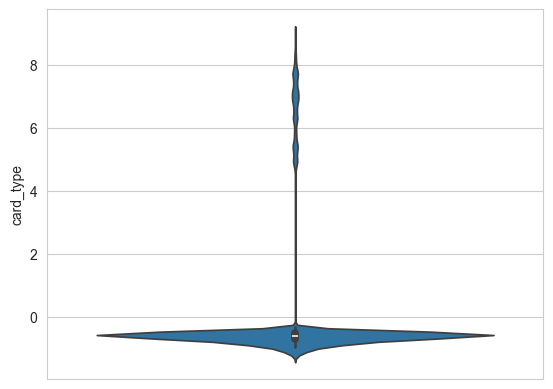

In [180]:
sns.violinplot(shap_df['card_type'])

##### В данном случае эти большие значения - артефакт. Т.к. они встречаются только у fraud примеров, где физически расплачивались картой (в датасете 100% таких операций - мошеннические), т.е. дело не в этом признаке.
Поэтому можно предположить, что и ранее импортанс данной фичи был не совсем настоящий.

In [243]:
X_train.reset_index()[shap_df['card_type'] > 4]['is_card_present'].value_counts()

is_card_present
True    521126
Name: count, dtype: int64

##### Влияние типа вендора более сбалансированное

<Axes: ylabel='vendor_type'>

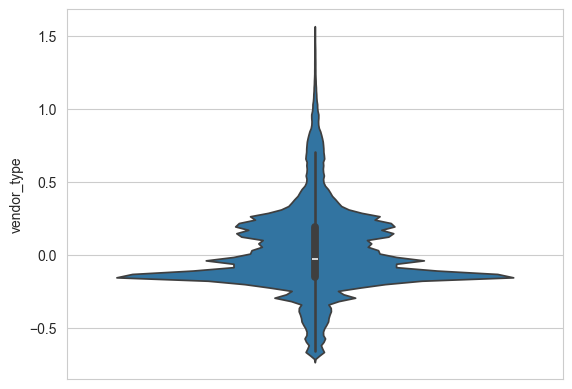

In [252]:
sns.violinplot(shap_df['vendor_type'])

Несколько экспериментов направленных на выявление потенциального влияния vendor_type на таргет (или доказательство его отсутствия) не увенчались успехом. Возможно существует более сложная закономерность или важность данного признака является артефактом

### Итоги

В ноутбуке был проделан разведочный анализ данных, в котором было проанализировано как мошеннические транзакции связаны с различными признаками. Как было видно, большинство признаков либо не влияют на таргет, либо часть значений категориальных признаков дает 100% вероятность мошеннической транзакции. Лишь для нескольких признаков характер взаимосвязи переменных более сложный. В конце была обучена модель, которая прекрасно обучилась предсказывать целевую переменную. Важность признаков для модели дополнила предварительные выводы информацией о их глобальной значимости.